In [ ]:
import fsspec

fs_read = fsspec.filesystem('s3', anon=True, skip_instance_cache=True, use_ssl=False) # For now SSL false is solving my cert issues **shrug**
fs_write = fsspec.filesystem('')

In [ ]:
# https://noaa-nws-rtofs-pds.s3.amazonaws.com/rtofs.20230922/rtofs_glo_2ds_f001_diag.nc
model_date = '20230922'
rtofs_files = fs_read.glob(f's3://noaa-nws-rtofs-pds/rtofs.{model_date}/rtofs_glo_2ds_f*_diag.nc')

rtofs_files = sorted(['s3://'+f for f in rtofs_files])
rtofs_files

In [10]:
def generate_json_filename(infilename: str):
    components = infilename.split('/')
    model_date = components[-2]
    filename = components[-1]
    return f'{model_date}.{filename}.zarr'

In [11]:
import ujson
from kerchunk.hdf import SingleHdf5ToZarr

outdir = 'rtofs'

def generate_json(f):
    outname = generate_json_filename(f)
    
    with fs_read.open(f) as ifile:
        chunks = SingleHdf5ToZarr(ifile, f)
        with fs_write.open(f'{outdir}/{outname}', 'w') as ofile:
            ofile.write(ujson.dumps(chunks.translate()))

    return outname

In [12]:
for i, f in enumerate(rtofs_files[0:4]):
    print(f'Processing {i+1} of {len(rtofs_files)}')
    print(generate_json(f))

print('Done')

Processing 1 of 73
rtofs.20230922.rtofs_glo_2ds_f000_diag.nc.zarr
Processing 2 of 73
rtofs.20230922.rtofs_glo_2ds_f001_diag.nc.zarr
Processing 3 of 73
rtofs.20230922.rtofs_glo_2ds_f002_diag.nc.zarr
Processing 4 of 73
rtofs.20230922.rtofs_glo_2ds_f003_diag.nc.zarr
Done


In [13]:
import re
import datetime
from typing import Tuple

def extract_forecast_time_index(key) -> Tuple[str, int]:
    model_date, offset = re.search(r'(\d{8}).*.f(\d{3})', key).groups()
    model_date = datetime.datetime.strptime(f'{model_date}T00', '%Y%m%dT%H') + datetime.timedelta(hours=int(offset))
    model_date_key = model_date.strftime('%Y%m%dT%H')
    return model_date_key, int(offset)

In [14]:
indexes = {}

rtofs_zarr_files = fs_write.glob(f'{outdir}/*.nc.zarr')

for f in rtofs_zarr_files:
    model_date_key, offset = extract_forecast_time_index(f)
    if model_date_key not in indexes:
        indexes[model_date_key] = [offset, f]
    else: 
        if offset < indexes[model_date_key][0]:
            indexes[model_date_key] = [offset, f]

rtofs_best_files = [x[1] for x in list(indexes.values())]
rtofs_best_files 

['/Users/matthewiannucci/Developer/ocean-notebooks/rtofs/rtofs.20230922.rtofs_glo_2ds_f000_diag.nc.zarr',
 '/Users/matthewiannucci/Developer/ocean-notebooks/rtofs/rtofs.20230922.rtofs_glo_2ds_f001_diag.nc.zarr',
 '/Users/matthewiannucci/Developer/ocean-notebooks/rtofs/rtofs.20230922.rtofs_glo_2ds_f002_diag.nc.zarr',
 '/Users/matthewiannucci/Developer/ocean-notebooks/rtofs/rtofs.20230922.rtofs_glo_2ds_f003_diag.nc.zarr']

In [15]:
from kerchunk.combine import MultiZarrToZarr
import ujson

mzz = MultiZarrToZarr(
    rtofs_best_files, 
    remote_protocol='s3', 
    remote_options={'anon': True, 'use_ssl': False},
    concat_dims=['MT'],
    identical_dims=['Y', 'X', 'Latitude', 'Longitude']
)

d = mzz.translate()

with fs_write.open(f'{outdir}/rtofs_glo_2ds_diag.best.zarr', 'wb') as f:
    f.write(ujson.dumps(d).encode())
    print('Successfully wrote kerchunked rtofs collection to disk')

Successfully wrote kerchunked rtofs collection to disk


In [18]:
import cf_xarray
import xarray as xr

# open dataset as zarr object using fsspec reference file system and xarray
fs = fsspec.filesystem("reference", fo='./rtofs/rtofs_glo_2ds_diag.best.zarr', remote_protocol='s3', remote_options={'anon':True, 'use_ssl': False})
m = fs.get_mapper("")

ds = xr.open_dataset(m, engine="zarr", backend_kwargs=dict(consolidated=False), chunks={})
ds

<xarray.Dataset>
Dimensions:                           (MT: 4, Y: 3298, X: 4500)
Coordinates:
    Date                              (MT) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    Latitude                          (Y, X) float32 dask.array<chunksize=(825, 1125), meta=np.ndarray>
    Longitude                         (Y, X) float32 dask.array<chunksize=(825, 1125), meta=np.ndarray>
  * MT                                (MT) datetime64[ns] 2023-09-22 ... 2023...
  * X                                 (X) int32 1 2 3 4 ... 4497 4498 4499 4500
  * Y                                 (Y) int32 1 2 3 4 ... 3295 3296 3297 3298
Data variables:
    mixed_layer_thickness             (MT, Y, X) float32 dask.array<chunksize=(1, 825, 1125), meta=np.ndarray>
    ssh                               (MT, Y, X) float32 dask.array<chunksize=(1, 825, 1125), meta=np.ndarray>
    surface_boundary_layer_thickness  (MT, Y, X) float32 dask.array<chunksize=(1, 825, 1125), meta=np.ndarray>
    u_barotropic_velocity             (MT, Y, X) float32 dask.array<chunksize=(1, 825, 1125), meta=np.ndarray>
    v_barotropic_velocity             (MT, Y, X) float32 dask.array<chunksize=(1, 825, 1125), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.0
    experiment:   92.8
    history:      archv2ncdf2d
    institution:  National Centers for Environmental Prediction
    source:       HYCOM archive file
    title:        HYCOM ATLb2.00

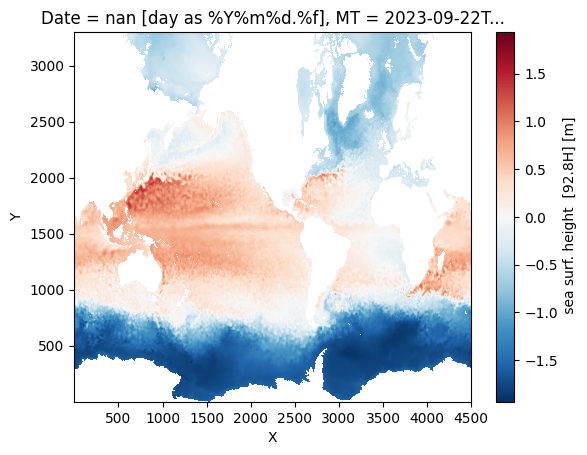

In [21]:
ds.ssh.cf.isel(time=1).plot()